In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"pothole": 0 }

In [3]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    '''
    Function to extract information from the XML file
    '''
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [4]:
random.seed(0)
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
def plot_bounding_box(image, annotation_list):
    '''
    Plots the bounding box on the image
    '''
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

In [5]:
def convert_to_yolov5(info_dict):
    '''
    Converts the annotation to YOLO v5 format
    '''
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("labels", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [6]:
def show_random_imglabels(imgs,labels,random_seed = None,number_rand_img = 3):
    '''
    Function to show random images with their labels
    '''
    if random_seed:
        random.seed(random_seed)
    randoms_index = random.sample(range(len(labels)),k = number_rand_img)
    
    for idx in randoms_index:
        image = Image.open(imgs[idx])
            # Get any random annotation file 
        annotation_file = labels[idx]
        with open(annotation_file, "r") as file:
            annotation_list = file.read().split("\n")[:-1]
            annotation_list = [x.split(" ") for x in annotation_list]
            annotation_list = [[float(y) for y in x ] for x in annotation_list]
            plot_bounding_box(image,annotation_list)

In [7]:
# Get the annotations
annotations = [os.path.join('annotated-images', x) for x in os.listdir('annotated-images') if x[-3:] == "xml"]
annotations.sort()

In [8]:
annotations[:5]

['annotated-images\\img-1.xml',
 'annotated-images\\img-10.xml',
 'annotated-images\\img-100.xml',
 'annotated-images\\img-101.xml',
 'annotated-images\\img-102.xml']

In [9]:
# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

  0%|          | 0/665 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'labels\\img-1.txt'

In [ ]:
image_train_dir = r'D:\FPT\ky5\AIP391\My Project\data\data_potholes\train\images'
label_train_dir = r'D:\FPT\ky5\AIP391\My Project\data\data_potholes\train\labels'
image_test_dir = r'D:\FPT\ky5\AIP391\My Project\data\data_potholes\test\images'
label_test_dir = r'D:\FPT\ky5\AIP391\My Project\data\data_potholes\test\labels'

In [ ]:
images = [x for x in os.listdir('annotated-images') if x[-3:] == "jpg"]
images.sort()
images[:5]

[]

In [ ]:
labels = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]
labels

['labels\\img-1.txt',
 'labels\\img-10.txt',
 'labels\\img-100.txt',
 'labels\\img-101.txt',
 'labels\\img-102.txt',
 'labels\\img-103.txt',
 'labels\\img-104.txt',
 'labels\\img-105.txt',
 'labels\\img-106.txt',
 'labels\\img-107.txt',
 'labels\\img-108.txt',
 'labels\\img-109.txt',
 'labels\\img-11.txt',
 'labels\\img-110.txt',
 'labels\\img-111.txt',
 'labels\\img-112.txt',
 'labels\\img-113.txt',
 'labels\\img-114.txt',
 'labels\\img-115.txt',
 'labels\\img-116.txt',
 'labels\\img-117.txt',
 'labels\\img-118.txt',
 'labels\\img-119.txt',
 'labels\\img-12.txt',
 'labels\\img-120.txt',
 'labels\\img-121.txt',
 'labels\\img-122.txt',
 'labels\\img-123.txt',
 'labels\\img-124.txt',
 'labels\\img-125.txt',
 'labels\\img-126.txt',
 'labels\\img-127.txt',
 'labels\\img-128.txt',
 'labels\\img-129.txt',
 'labels\\img-13.txt',
 'labels\\img-130.txt',
 'labels\\img-131.txt',
 'labels\\img-132.txt',
 'labels\\img-133.txt',
 'labels\\img-134.txt',
 'labels\\img-135.txt',
 'labels\\img-136.txt'

In [ ]:
images = [os.path.join(image_train_dir, x) for x in os.listdir(image_train_dir)]
labels = [os.path.join(label_train_dir, x) for x in os.listdir(label_train_dir)]
images[1],labels[1]

('D:\\FPT\\ky5\\AIP391\\My Project\\data\\data_potholes\\train\\images\\img-100.jpg',
 'D:\\FPT\\ky5\\AIP391\\My Project\\data\\data_potholes\\train\\labels\\img-100.txt')

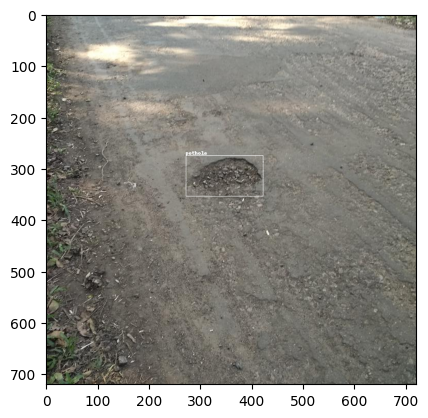

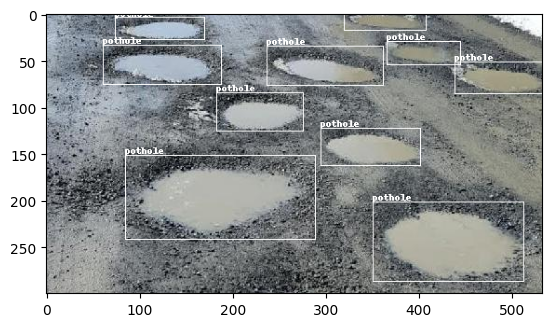

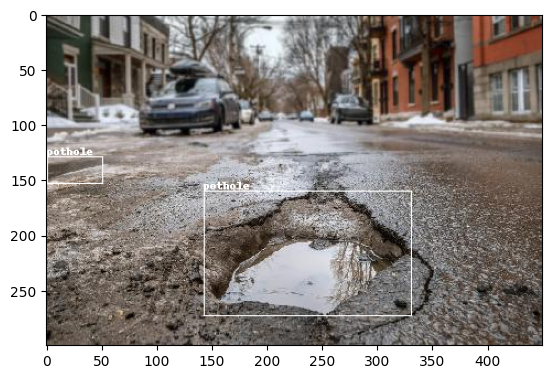

In [ ]:
show_random_imglabels(images,labels,number_rand_img = 3)

In [ ]:
# delete img in folder
def delete_img(my_path):
    for file in os.listdir(my_path):
        os.remove(os.path.join(my_path, file))

-37

## split data

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = 1)

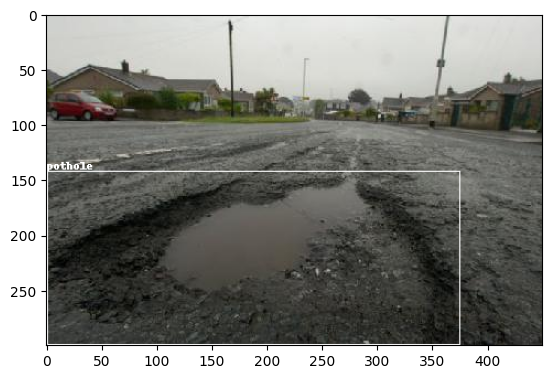

In [ ]:
show_random_imglabels(train_images,train_labels,random_seed = 0,number_rand_img = 1)

In [3]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    '''
    Utility function to move files to a folder
    '''
    destination_folder = Path(destination_folder)
    for f in list_of_files:
        try:
            f = Path(f)
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

In [5]:
import re
a = r'D:\FPT\ky5\AIP391\My Project\data\data_potholes\test\images'
b = r'D:\FPT\ky5\AIP391\My Project\data\data_potholes\test\labels'
train_rotated_images = [os.path.join(a, x) for x in os.listdir(a) if re.search(r'color', x)]
train_rotated_labels = [os.path.join(b, x) for x in os.listdir(b) if re.search(r'color', x)]
move_files_to_folder(train_rotated_images, r'D:\FPT\ky5\AIP391\My Project\data\data_color_fillter\test\images')
move_files_to_folder(train_rotated_labels, r'D:\FPT\ky5\AIP391\My Project\data\data_color_fillter\test\labels')
